# Tutorial de Big Data
## Bienvenidos a la clase 2

### Temario:

- Introducción a tweepy, textblob, nltk
- Ejercicio práctico: Analisis de sentimiento de tweets de Joe Biden pre y post elecciones
- Introducción a la Tarea 1 parte 2 

### Respuestas a las preguntas de los videos:

### Analisis de sentimiento de tweets de Joe Biden pre y post elecciones

In [288]:
#importamos los paquetes a utilizar
import os
import re
import string
import pandas as pd
import tweepy
from textblob import TextBlob
from datetime import datetime

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Crear con Sublime (u otro editor de texto) un archivo llamado `twitter_keys.txt` dentro de la carpeta `clase5` y guardar las 4 claves, una por línea, en el siguiente orden:
- API key
- API key secret
- Access token
- Access token secret

In [143]:
#Creamos variables que contienen nuestas claves de autenticación con la API
with open("twitter_keys.txt") as tw_k: 
    consumer_key = tw_k.readline().strip()
    consumer_secret = tw_k.readline().strip()
    access_key = tw_k.readline().strip()
    access_secret = tw_k.readline().strip()

In [144]:
#Le pasamos nuestras credenciales de twitter a tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [145]:
new_tweets = api.user_timeline(screen_name = "JoeBiden")
new_tweets

[Status(_api=<tweepy.api.API object at 0x000001E26D8EDE88>, _json={'created_at': 'Sun Aug 22 18:03:19 +0000 2021', 'id': 1429504471395078144, 'id_str': '1429504471395078144', 'text': 'RT @POTUS: Today at 4 PM ET I will address the nation on my Administration’s response to Tropical Storm Henri, and give an update on the ev…', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'POTUS', 'name': 'President Biden', 'id': 1349149096909668363, 'id_str': '1349149096909668363', 'indices': [3, 9]}], 'urls': []}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 939091, 'id_str': '939091', 'name': 'Joe Biden', 'screen_name': 'JoeBiden', 'location': 'Washington, DC', 'description': 'Husband to @DrBiden, proud father and grandfather. 

In [146]:
def get_all_tweets(screen_name, start_date):
    '''
    Esta funcion recibe el nombre de la persona de quien queremos extraer los 
    tweets y devuelve una lista con todos los tweets y sus datos
    Input: 
      screen_name (str): el nombre de la persona en twitter
    Output:
      all_tweets (lista): lista con todos los tweets extraidos
    '''
    # Solicitamos los 200 tweets mas recientes (200 es el maximo permitido en count)
    new_tweets = api.user_timeline(screen_name=screen_name, 
                                   tweet_mode="extended", count=200)
    # Creo una lista para almacenar TODOS los tweets y agrego los recién extraidos
    all_tweets = []
    all_tweets.extend(new_tweets)
    # guardo el id del ultimo tweet extraído 
    oldest = all_tweets[-1].id 
    
    # extraigo tweets de a 200 hasta que no haya más
    while len(new_tweets) > 0 and all_tweets[-1].created_at > start_date:
        # Solicito 200 tweets mas y los agrego a la lista de 'all_tweets'
        new_tweets = api.user_timeline(screen_name=screen_name, count=200,
                                       tweet_mode="extended", max_id=oldest-1)
        all_tweets.extend(new_tweets)
        # actualizo el id del ultimo tweet extraído
        oldest = all_tweets[-1].id 
        print("Hasta ahora se han extraido %s tweets" % len(all_tweets))

    return all_tweets


In [147]:
date_before_elections = datetime(2020, 10, 16, 0, 0, 0)
all_tweets_biden = get_all_tweets("JoeBiden", date_before_elections)

Hasta ahora se han extraido 400 tweets
Hasta ahora se han extraido 600 tweets
Hasta ahora se han extraido 800 tweets
Hasta ahora se han extraido 1000 tweets
Hasta ahora se han extraido 1200 tweets
Hasta ahora se han extraido 1200 tweets


In [148]:
#Veamos la lista con los primeros 5 tweets 
all_tweets_biden[:5]


[Status(_api=<tweepy.api.API object at 0x000001E26D8EDE88>, _json={'created_at': 'Sun Aug 22 18:03:19 +0000 2021', 'id': 1429504471395078144, 'id_str': '1429504471395078144', 'full_text': 'RT @POTUS: Today at 4 PM ET I will address the nation on my Administration’s response to Tropical Storm Henri, and give an update on the ev…', 'truncated': False, 'display_text_range': [0, 140], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'POTUS', 'name': 'President Biden', 'id': 1349149096909668363, 'id_str': '1349149096909668363', 'indices': [3, 9]}], 'urls': []}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 939091, 'id_str': '939091', 'name': 'Joe Biden', 'screen_name': 'JoeBiden', 'location': 'Washington, DC', 'description': 'Husband to @Dr

In [149]:
def save_tweets_text(all_tweets, csv_file=None):
    '''
    Esta función guarda los tweets en un data frame y si se especifica un 
    archivo csv tambien se guardaran ahí 
    Input:
        all_tweets (lista): lista con tweets y sus datos
        csv_file ('str'): nombre del archivo csv
    Output:
        df_all_tweets (df): tweets ordenados en una tabla con datos seleccinados
    '''
    all_tweets_selection = []
    for tweet in all_tweets:
        one_tweet = [tweet.id_str, tweet.created_at, tweet.full_text, 
                     tweet.retweeted, tweet.favorite_count, 
                     tweet.in_reply_to_screen_name]
        all_tweets_selection.append(one_tweet)
    
    df_all_tweets = pd.DataFrame(all_tweets_selection)
    df_all_tweets.columns = ['id_str', 'created_at', 'text', 'retweeted',
                            'favorite_count', 'in_reply_to_screen_name']
    if csv_file:
        df_all_tweets.to_csv(csv_file, index=False, encoding="utf-8")

    return df_all_tweets

In [150]:
df_all_tweets = save_tweets_text(all_tweets_biden, "tweets.csv")
df_all_tweets

,id_str,created_at,text,retweeted,favorite_count,in_reply_to_screen_name
0,1429504471395078144,2021-08-22 18:03:19,RT @POTUS: Today at 4 PM ET I will address the...,False,0,None
1,1428130239016747016,2021-08-18 23:02:37,RT @POTUS: We will not sit by as Governors try...,False,0,None
2,1428058056672247813,2021-08-18 18:15:47,Human rights must be the center of our foreign...,False,18101,None
3,1428026091386679301,2021-08-18 16:08:46,RT @WhiteHouse: The COVID-19 vaccines are safe...,False,0,None
4,1427712487072227337,2021-08-17 19:22:37,The answer is clear: We cannot continue to rep...,False,27902,None
...,...,...,...,...,...,...
1195,1318286327721480194,2020-10-19 20:22:07,...yes https://t.co/LZyAQugqoW,False,465680,None
1196,1318275726752256000,2020-10-19 19:40:00,Early voting starts today in:\n\nAlaska\nArkan...,False,18865,None
1197,1318266163726487558,2020-10-19 19:02:00,This election is about so much more than polic...,False,29801,None
1198,1318237222764642304,2020-10-19 17:07:00,It’s long past time we build an economy that r...,False,24998,None


In [151]:
# Emoticons contentos
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Emoticons Tristes
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [152]:
#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # simbolos & pictogramas
                           u"\U0001F680-\U0001F6FF"  # transporte & simbolos mapas
                           u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)


In [153]:
#mrhod clean_tweets()
def clean_tweets(tweet):
    '''
    Esta función limpia el texto del tweet. Elimina emoticones, palabras vacías,
    links, indicaciones de retweets, etc. Para dejar en el texto solo las
    palabras con mayor contenido.
    Input:
        tweet (str): Texto del tweet original
    Output:
        tweet (str): Texto del tweet limpiado
    '''
    #Elimino caracteres de re-tweets   
    tweet = re.sub(r'^RT .*:', '', tweet)
    tweet = re.sub(r'@\S+', '', tweet)
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #Reemplazo caracteres non-ASCII con espacio
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #Saco los links
    tweet = re.sub(r'https.*', '', tweet)
    #Saco los emoji
    tweet = emoji_pattern.sub(r'', tweet)
    
    #Separo los tweets in tokens
    word_tokens = nltk.tokenize.word_tokenize(tweet)
    #Obtengo set de palabras vacias para luego eliminarlas
    stop_words = set(nltk.corpus.stopwords.words('english'))
    
    #loop por las condiciones
    filtered_tweet = []
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and \
           w not in string.punctuation:
            filtered_tweet.append(w)

    
    return ' '.join(filtered_tweet)

In [154]:
#Este es un tweet sucio:
df_all_tweets.iloc[3]['text']

'RT @WhiteHouse: The COVID-19 vaccines are safe, free, and highly effective – but even highly effective vaccines experience a reduction in p…'

In [155]:
#Este es un tweet limpio:
clean_tweets(df_all_tweets.iloc[3]['text'])

'The COVID-19 vaccines safe free highly effective even highly effective vaccines experience reduction p'

In [156]:
start_time = datetime.strptime("2020-10-20", '%Y-%m-%d')
end_time = datetime.strptime("2020-11-18", '%Y-%m-%d')

def filter_year_and_month(date, start_time, end_time):
    '''
    Recibe una fecha y devuelve True, si la fecha de la fila esta 
    dentro de los dias especificados como inicio y fin, caso 
    contrario False.
    '''
    dd = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
    return dd > start_time and dd < end_time


In [157]:
def generate_sentiment(texto):
    '''
    Esta funcion limpia el texto y analiza el sentimiento.
    Input:
        texto (str): texto a limpiar y analizar
    Output:
         polarity (float): en el rango [-1.0, 1.0] 
         subjectivity (float): en el rango [0.0, 1.0] 
    '''
    # Limpiamos el texto del tweet
    filtered_tweet = clean_tweets(texto)
    # Calculamos el sentimiento con el metodo TextBlob
    blob = TextBlob(filtered_tweet)
    Sentiment = blob.sentiment

    polarity = Sentiment.polarity
    subjectivity = Sentiment.subjectivity            

    return polarity, subjectivity
    

In [158]:
def add_sentiment(df, start_time, end_time):
    '''
    Esta funcion filtra los tweets entre las fechas de inicio y fin
    indicadas y agrega dos columnas, una de polarity y otra de subjectivity.
    Input:
        df (dataframe): tabla con los tweets en una columa llamada text
        start_time (datetime): fecha del tweet más antiguo a conservar
        end_time (datetime): fecha del tweet más reciente a conservar
    Output:
        df (dataframe): df actualizado con el filtro y nuevas columnas
    '''
    df = df[df.apply(lambda row: filter_year_and_month(row['created_at'], 
                                                start_time, end_time), axis=1)]

    df[["polarity", "subjectivity"]] = pd.DataFrame(df.apply(lambda row: \
                                            generate_sentiment(row['text']), \
                                            axis=1).tolist(), index=df.index)
    
    return df

In [202]:
tweets_sentimiento = add_sentiment(df_all_tweets, start_time, end_time)
tweets_sentimiento

C:\Users\usuario\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,id_str,created_at,text,retweeted,favorite_count,in_reply_to_screen_name,polarity,subjectivity
678,1328837822950752259,2020-11-17 23:10:00,"Today, @KamalaHarris and I met with some of ou...",False,116359,None,0.500000,0.700000
679,1328790008963227649,2020-11-17 20:00:00,I’m keeping in my prayers all of our friends a...,False,267025,None,0.266667,0.583333
680,1328734005404061701,2020-11-17 16:17:28,RT @Transition46: Our White House senior staff...,False,0,None,0.000000,0.000000
681,1328474177007972354,2020-11-16 23:05:00,Americans want us to cooperate. They want us t...,False,133727,None,0.500000,0.812500
682,1328467885279375361,2020-11-16 22:40:00,"When we build back better, we will do so with ...",False,196026,None,0.250000,0.285714
...,...,...,...,...,...,...,...,...
1188,1318561610235981824,2020-10-20 14:36:00,"The simple, sad truth is that this president i...",False,60019,None,-0.166667,0.452381
1189,1318361290306392064,2020-10-20 01:20:00,Pennsylvania — there are just a few hours left...,False,18249,None,0.000000,0.000000
1190,1318357515680116737,2020-10-20 01:05:00,"For once, Donald Trump is correct: I will list...",False,210362,None,0.000000,0.000000
1191,1318352230458609664,2020-10-20 00:44:00,I will be a president who pushes towards the f...,False,338984,None,-0.125000,0.187500


## Trabajo Practico 1 - Parte 2

### Reglas de formato y presentación
- El trabajo debe estar bien comentado (utilizando #) para que el codigo sea facíl de entender por sus compañeros y profesores.

- El mismo debe ser completado en este Jupyter Notebook y entregado como tal, es decir en un archivo .ipynb


### Fecha de entrega:
Lunes 23/8 a las 23:59hs

### Modalidad de entrega
- Al finalizar el trabajo práctico deben hacer un último <i>commit</i> en su repositorio de GitHub con el mensaje “Entrega final del tp”. 
- Asegurense de haber creado una carpeta llamada TP1. Este Jupyter Notebook y el correspondiente al TP1 - Parte 1 deben estar dentro de esa carpeta.
- Tambíen deben completar el link de su repositorio -para que pueda ser clonado y corregido- en la siguiente google sheet: https://docs.google.com/spreadsheets/d/1qaXCveEw3MjEwXQsu2zpqUz34BiaCMR0WapcsQ7jGs0/edit?usp=sharing
- La última versión en el repositorio es la que será evaluada. Por lo que es importante que: 
    - No completen la google sheet hasta no haber terminado y estar seguros de que han hecho el <i>commit y push</i> a la versión final que quieren entregar. Debido a que se pueden tomar hasta 3 días de extensión a lo largo del curso, yo no corregiré sus tareas hasta no ver el link en la google sheet.
    - No hagan nuevos <i>push</i> despues de habér entregado su versión final. Esto generaría confusión acerca de que versión es la que quieren que se les corrija. 

#### Ejercicio 1: 
Impriman algunos de los tweets más negativos (filtrando por la columna de `polarity`) y su fecha

In [203]:
#ordenamos segun polaridad primero y luego según fecha. Polaridad decreciente (del más bajo al más alto)
#usamos un dataframe nuevo para evitar errores
tweets_sentimiento_1 = tweets_sentimiento.sort_values(by = ['polarity', 'created_at'])

#chequeamos que funcione
tweets_sentimiento_1[:5]

,id_str,created_at,text,retweeted,favorite_count,in_reply_to_screen_name,polarity,subjectivity
831,1323457369670512641,2020-11-03 02:50:00,After tonight's horrific terrorist attack in V...,False,98030,None,-0.900000,0.950000
701,1326325015290273792,2020-11-11 00:45:00,"If you’re sick, if you’re struggling, if you’r...",False,185775,None,-0.714286,0.857143
1192,1318342919305166850,2020-10-20 00:07:00,.@realDonaldTrump — if you had listened to the...,False,77548,None,-0.700000,0.666667
1175,1318674605192761350,2020-10-20 22:05:00,Listening to scientists is not a bad thing.\n\...,False,426570,None,-0.700000,0.666667
693,1327356814552305664,2020-11-13 21:05:00,Today marks five years since the horrific ISIS...,False,209882,None,-0.650000,0.750000


#### Ejercicio 2: 
Impriman algunos de los tweets más positivos (filtrando por la columna de `polarity`) y su fecha

In [204]:
#ordenamos segun polaridad primero y luego según fecha. Polaridad decreciente (del más alto al más bajo)
#usamos un dataframe nuevo para evitar errores
tweets_sentimiento_2 = tweets_sentimiento.sort_values(by = ['polarity', 'created_at'], ascending =False)
          
#chequeamos que funcione    
tweets_sentimiento_2[:5]

,id_str,created_at,text,retweeted,favorite_count,in_reply_to_screen_name,polarity,subjectivity
1176,1318654724057518080,2020-10-20 20:46:00,America is a nation that values immigrants. It...,False,26512,None,1.0,1.00
685,1328338891544387585,2020-11-16 14:07:25,"Once again, I congratulate the brilliant women...",False,125281,JoeBiden,0.9,1.00
991,1321915963399352321,2020-10-29 20:45:00,Christen — tell your grandmother I’m incredibl...,False,134907,None,0.9,0.90
699,1326557341697839106,2020-11-11 16:08:11,"Today, we honor the service of those who have ...",False,351041,None,0.8,1.00
724,1325255719336243200,2020-11-08 01:56:00,Now that the campaign is over—what is the peop...,False,242670,None,0.8,0.75


#### Ejercicio 3: 
Agreguenle al df llamado `tweets_sentimiento` una nueva columna llamada `positivo` que tenga:
- 1 cuando el tweet tiene polarity > 0, 
- 0 cuando el tweet tiene polarity = 0, 
- 1 cuando el tweet tiene polarity < 0 

In [259]:
#armamos las condiciones
conditions = [
    (tweets_sentimiento['polarity'] > 0),
        (tweets_sentimiento['polarity'] == 0),
    (tweets_sentimiento['polarity'] < 0)
    ]
#definimos los valores que toma cada posicion
values = [1, 0, -1]

#incorporamos la nueva columna "positivo" dadas las condiciones y los valores que toman
tweets_sentimiento['positivo'] = np.select(conditions, values)

#chequeamos que funcione
tweets_sentimiento[200:206]
    

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,id_str,created_at,text,retweeted,favorite_count,in_reply_to_screen_name,polarity,subjectivity,positivo
878,1323096239970373638,2020-11-02 02:55:00,"When Donald Trump thinks about climate change,...",False,24761,None,0.200000,0.200000,1
879,1323087935411924993,2020-11-02 02:22:00,This is our moment to root out systemic racism...,False,14403,None,0.137500,0.337500,1
880,1323082401774329856,2020-11-02 02:00:00,"A more hopeful, united, and loving America is ...",False,16741,None,0.600000,0.950000,1
881,1323077868990193672,2020-11-02 01:42:00,Donald Trump’s COVID-19 response has been the ...,False,172795,None,0.341667,0.650000,1
882,1323073590749614080,2020-11-02 01:25:00,From Arizona to Georgia to Wisconsin and beyon...,False,37656,None,-0.145833,0.304167,-1
883,1323069815880327173,2020-11-02 01:10:00,"Under my tax plan, no one making under $400,00...",False,133843,None,0.457143,0.664286,1


#### Ejercicio 4: 
Agrupen los tweets por día y promedien el la polaridad. Luego hagan un gráfico con el sentimiento por día.

In [295]:
#duplcamos la serie para evitar errores
tweets_sentimiento_3 = tweets_sentimiento.copy()

#seleccionamos las columnas que nos interesan
tweets_sentimiento_4= tweets_sentimiento_3[['created_at', 'polarity']]

#chequeamos que funcione
tweets_sentimiento_4[:5]

,created_at,polarity
678,2020-11-17 23:10:00,0.500000
679,2020-11-17 20:00:00,0.266667
680,2020-11-17 16:17:28,0.000000
681,2020-11-16 23:05:00,0.500000
682,2020-11-16 22:40:00,0.250000


In [318]:
#agrupamos por fecha
tweets_sentimiento_5= tweets_sentimiento_4.resample('D', on='created_at').polarity.mean()
#chequeamos que funcione
tweets_sentimiento_5[:5]


created_at
2020-10-20   -0.006932
2020-10-21    0.122063
2020-10-22    0.132929
2020-10-23    0.122758
2020-10-24    0.035287
Freq: D, Name: polarity, dtype: float64

In [320]:
#convertimos a DataFrame
tweets_sentimiento_6 = tweets_sentimiento_5.to_frame()
tweets_sentimiento_6.index.name = 'fecha'
tweets_sentimiento_6.reset_index(inplace=True)

#chequeamos que funcione
tweets_sentimiento_6[:5]

     

,fecha,polarity
0,2020-10-20,-0.006932
1,2020-10-21,0.122063
2,2020-10-22,0.132929
3,2020-10-23,0.122758
4,2020-10-24,0.035287


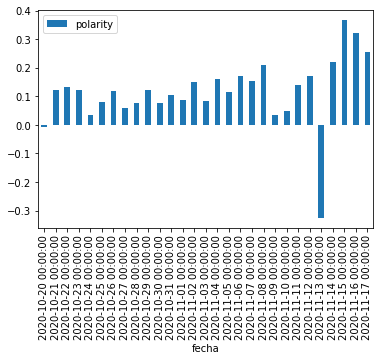

In [323]:
#graficamos
tweets_sentimiento_6.plot(x ='fecha', y='polarity', kind = 'bar')
plt.show()

#### Repaso del análisis de sentimiento: 
Por último, los invito a que exploren el análisis de sentimiento de forma teórica y práctica:
- Revisen la documentación de `TextBlob` y del método `sentiment` https://textblob.readthedocs.io/en/dev/ 
- Prueben en la practica el resultado que arroja para determinadas frases (les dejo unos ejemplos, pero pueden probar los que quieran)


In [ ]:
blob = TextBlob('good')
blob.sentiment

In [ ]:
blob = TextBlob('bad')
blob.sentiment

In [ ]:
blob = TextBlob('Hate the quarentine')
blob.sentiment

In [ ]:
blob = TextBlob('Love my life')
blob.sentiment

In [311]:
blob = TextBlob('excellent')
blob.sentiment

Sentiment(polarity=1.0, subjectivity=1.0)

In [312]:
blob = TextBlob('fun')
blob.sentiment

Sentiment(polarity=0.3, subjectivity=0.2)

In [313]:
blob = TextBlob('amazing')
blob.sentiment

Sentiment(polarity=0.6000000000000001, subjectivity=0.9)